# Portfolio Optimization

In [77]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

In [78]:
# Function to read data and calculate daily returns
raw_data_path = '../data/raw/'
processed_data_path = '../data/processed/'
stocks = ['AAPL', 'AMZN', 'EEM', 'GLD', 'JNJ', 'JPM', 'SPY', 'TSLA']
training_data = [f"{raw_data_path}{stock}_training_data.csv" for stock in stocks]
validation_data = [f"{raw_data_path}{stock}_validation_data.csv" for stock in stocks]

In [79]:
def load_data(files, train: bool):
    data = {}
    for file in files:
        df = pd.read_csv(file, index_col='Date', parse_dates=True)
        data[file.split('/')[-1].split('_')[0]] = df['Close']
    data = pd.DataFrame(data)
    if train:
        data.to_csv(processed_data_path + 'training_prices.csv')
    else:
        data.to_csv(processed_data_path + 'validation_prices.csv')
    return data

def get_current_tbill_rate():
    # Fetching the 3-month T-Bill yield
    tbill = yf.Ticker("^IRX")  # 13-week Treasury bill
    hist = tbill.history(period="1d")
    current_yield = hist['Close'].iloc[-1]  # Get the last closing yield
    return current_yield / 100  # Convert to a decimal format

# Calculate portfolio performance metrics
def portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate=0.01):
    returns = np.sum(mean_returns * weights) * 252
    std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    sharpe_ratio = (returns - risk_free_rate) / std_dev
    return std_dev, returns, sharpe_ratio

def check_sum(weights):
    return np.sum(weights) - 1  # Weights must sum to 1

constraints = ({'type': 'eq', 'fun': check_sum})

def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    return -portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate)[2]

def maximize_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate=0.01):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    bounds = tuple((-1, 1) for asset in range(num_assets))
    initial_guess = num_assets * [1./num_assets,]
    result = minimize(negative_sharpe_ratio, initial_guess, args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result

risk_free_rate = get_current_tbill_rate()
print(f"Current 3-month T-Bill rate: {risk_free_rate:.4%}")
# Current 3-month T-Bill rate: 5.2450% (last run)

Current 3-month T-Bill rate: 5.2380%


In [80]:
# There are 249 pieces of data from 2023-04-01 to 2024-04-01
training_prices = load_data(training_data, train=True)
test_prices = load_data(validation_data, train=False)
returns = training_prices.pct_change().dropna()
mean_returns = returns.mean()
cov_matrix = returns.cov()
risk_free_rate = 0.05245

In [81]:
optimal_portfolio = maximize_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
portfolio_volatility = None
mu = None
if optimal_portfolio.success:  # Check if the optimization was successful
    print("Optimal portfolio list:", stocks)
    print("Optimal portfolio weights:", optimal_portfolio.x)
    vol, ret, sharpe = portfolio_performance(optimal_portfolio.x, mean_returns, cov_matrix, risk_free_rate)
    portfolio_volatility = vol
    mu = ret
    print("Expected annual return:", ret)
    print("Volatility:", vol)
    print("Sharpe Ratio:", sharpe)
else:
    print("Optimization did not converge:", optimal_portfolio.message)

Optimal portfolio list: ['AAPL', 'AMZN', 'EEM', 'GLD', 'JNJ', 'JPM', 'SPY', 'TSLA']
Optimal portfolio weights: [ 0.86257053  0.36652827 -1.          0.88550737 -0.59832703  0.64971009
 -0.35608242  0.19009318]
Expected annual return: 0.9824008731891937
Volatility: 0.29327101063838285
Sharpe Ratio: 3.1709607818546632


In [82]:
weights = optimal_portfolio.x
current_prices = training_prices.iloc[-1, :]
current_portfolio_value = np.dot(current_prices, weights)
expected_annual_return = mu
print("Current Portfolio Value:", current_portfolio_value)
print("Portfolio Volatility:", portfolio_volatility)
print("Expected annual return:", expected_annual_return)

Current Portfolio Value: 245.25718132783425
Portfolio Volatility: 0.29327101063838285
Expected annual return: 0.9824008731891937


## Efficient Frontier Visualization

In [83]:
## Efficient Frontier Visualization
ef_port = pd.DataFrame(mean_returns)
ef_port = pd.merge(ef_port, pd.DataFrame(returns.std()), on = ef_port.index)
ef_port.columns = ['permno', 'ret', 'std']
ef_port['ret'] = ef_port['ret'] * 252
ef_port['std'] = ef_port['std'] * np.sqrt(252)
ef_port = pd.concat([ef_port, pd.DataFrame({'permno':['PORT'], 'ret': [ret], 'std': [vol]})])

In [84]:
def plot_efficient_frontier(mean_returns, cov_matrix, risk_free_rate, num_portfolios=1001, ef_port=None):
    num_assets = len(mean_returns)
    results = np.zeros((3, num_portfolios))
    weights_record = []
    
    target_returns = np.linspace(0, 1, num_portfolios)
    for i, target_return in enumerate(target_returns):
        constraints = ({
            'type': 'eq', 
            'fun': lambda x: portfolio_performance(x, mean_returns, cov_matrix, risk_free_rate)[1] - target_return
        }, {
            'type': 'eq', 
            'fun': lambda x: np.sum(x) - 1
        })
        bounds = tuple((-1, 1) for asset in range(num_assets))
        result = minimize(
            lambda x: portfolio_performance(x, mean_returns, cov_matrix, risk_free_rate)[0], 
            num_assets * [1. / num_assets,],
            method='SLSQP', 
            bounds=bounds, 
            constraints=constraints
        )
        if result.success:
            std_dev, returns, sharpe_ratio = portfolio_performance(result.x, mean_returns, cov_matrix, risk_free_rate)
            results[0, i] = std_dev
            results[1, i] = returns
            results[2, i] = sharpe_ratio
            weights_record.append(result.x)

    plt.figure(figsize=(10, 6))
    plt.scatter(results[0], results[1], c=results[2], cmap='viridis', marker='o')
    plt.title('Efficient Frontier with Specific Stocks')
    plt.xlabel('Portfolio Risk')
    plt.ylabel('Portfolio Return')
    plt.colorbar(label='Sharpe Ratio')
    
    if ef_port is not None:
        plt.scatter(ef_port['std'], ef_port['ret'], c='red', marker='D', s=50, label='Stocks')
        for i, txt in enumerate(ef_port['permno']):
            plt.annotate(txt, (ef_port['std'].iloc[i], ef_port['ret'].iloc[i]))

    plt.legend()
    plt.show()

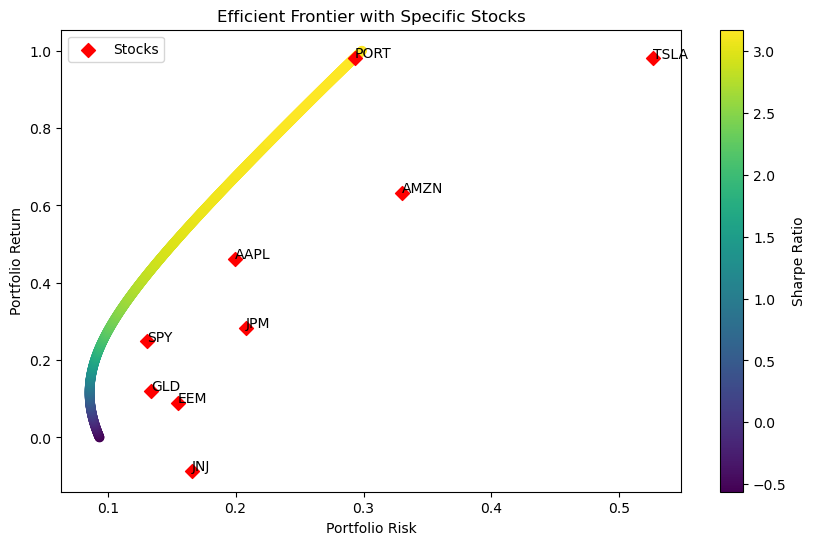

In [85]:
plot_efficient_frontier(mean_returns, cov_matrix, risk_free_rate, num_portfolios=1000, ef_port=ef_port)

## Portfolio Optimization on Simulated Prices

In [86]:
# processed_data_path = '../data/processed/'
cev_data = pd.read_csv(processed_data_path + 'simulated_prices_cev.csv', index_col=0)
heston_data = pd.read_csv(processed_data_path + 'simulated_prices_heston.csv', index_col=0)
gbm_data = pd.read_csv(processed_data_path + 'simulated_prices_gbm.csv', index_col=0)
merton_data = pd.read_csv(processed_data_path + 'simulated_prices_merton.csv', index_col=0)
gbm_data.index = cev_data.index
merton_data.index = cev_data.index
result = pd.concat([cev_data, gbm_data, heston_data, merton_data], axis=1)
new_order = ['AAPL', 'AMZN', 'EEM', 'GLD', 'JNJ', 'JPM', 'SPY', 'TSLA']
result = result[new_order]
result_returns = result.pct_change().dropna()
mean_returns = result_returns.mean()
cov_matrix = result_returns.cov()
risk_free_rate = 0.05245

In [87]:
test_optimal_portfolio = maximize_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
portfolio_volatility = None
mu = None
if test_optimal_portfolio.success:  # Check if the optimization was successful
    print("Optimal portfolio list:", stocks)
    print("Optimal portfolio weights:", test_optimal_portfolio.x)
else:
    print("Optimization did not converge:", optimal_portfolio.message)

Optimal portfolio list: ['AAPL', 'AMZN', 'EEM', 'GLD', 'JNJ', 'JPM', 'SPY', 'TSLA']
Optimal portfolio weights: [ 0.01711089 -0.03410461  0.01907691  0.44381825 -0.01318274  0.08020759
  0.48842751 -0.0013538 ]


 ## Performance Comparison

In [88]:
test_prices

,AAPL,AMZN,EEM,GLD,JNJ,JPM,SPY,TSLA
Date,,,,,,,,
2024-01-02 00:00:00-05:00,185.403412,149.929993,39.740002,190.720001,158.764557,170.033585,471.186005,248.419998
2024-01-03 00:00:00-05:00,184.015198,148.470001,39.520000,189.130005,159.757019,169.292496,467.337982,238.449997
2024-01-04 00:00:00-05:00,181.678177,144.570007,39.389999,189.320007,159.419586,170.415939,465.832642,237.929993
2024-01-05 00:00:00-05:00,180.949097,145.240005,39.439999,189.350006,159.915817,171.270966,466.470673,237.490005
2024-01-08 00:00:00-05:00,185.323517,149.100006,39.549999,187.869995,160.312790,171.022415,473.129974,240.449997
...,...,...,...,...,...,...,...,...
2024-03-22 00:00:00-04:00,172.279999,178.869995,40.860001,200.350006,155.229996,195.479736,521.210022,170.830002
2024-03-25 00:00:00-04:00,170.850006,179.710007,40.889999,200.990005,155.220001,193.690186,519.770020,172.630005
2024-03-26 00:00:00-04:00,169.710007,178.300003,40.860001,201.639999,155.770004,194.594894,518.809998,177.669998


In [89]:
test_returns = test_prices.pct_change().dropna()
test_mean_returns = test_returns.mean()
test_cov_matrix = test_returns.cov()
test_vol1, test_ret1, test_sharpe1 = portfolio_performance(optimal_portfolio.x, test_mean_returns,test_cov_matrix, risk_free_rate)
print("Portfolio Performance Using Optimized Weight from Historical Price")
print("Optimal portfolio weights:", optimal_portfolio.x)
print("Expected annual return:", test_ret1)
print("Volatility:", test_vol1)
print("Sharpe Ratio:", test_sharpe1)

Portfolio Performance Using Optimized Weight from Historical Price
Optimal portfolio weights: [ 0.86257053  0.36652827 -1.          0.88550737 -0.59832703  0.64971009
 -0.35608242  0.19009318]
Expected annual return: 0.20086236848655734
Volatility: 0.22385806865371366
Sharpe Ratio: 0.6629752922425889


In [90]:
test_vol2, test_ret2, test_sharpe2 = portfolio_performance(test_optimal_portfolio.x, test_mean_returns,test_cov_matrix, risk_free_rate)
print("Portfolio Performance Using Optimized Weight from Simulated Price")
print("Optimal portfolio weights:", test_optimal_portfolio.x)
print("Expected annual return:", test_ret2)
print("Volatility:", test_vol2)
print("Sharpe Ratio:", test_sharpe2)

Portfolio Performance Using Optimized Weight from Simulated Price
Optimal portfolio weights: [ 0.01711089 -0.03410461  0.01907691  0.44381825 -0.01318274  0.08020759
  0.48842751 -0.0013538 ]
Expected annual return: 0.38687192048316926
Volatility: 0.0820691831061509
Sharpe Ratio: 4.074878143366156


In [91]:
portfolio_path_old = result @ optimal_portfolio.x
portfolio_path_old = pd.DataFrame(portfolio_path_old, columns=['Portfolio Value'])
portfolio_path_new = result @ test_optimal_portfolio.x
portfolio_path_new = pd.DataFrame(portfolio_path_new, columns=['Portfolio Value'])

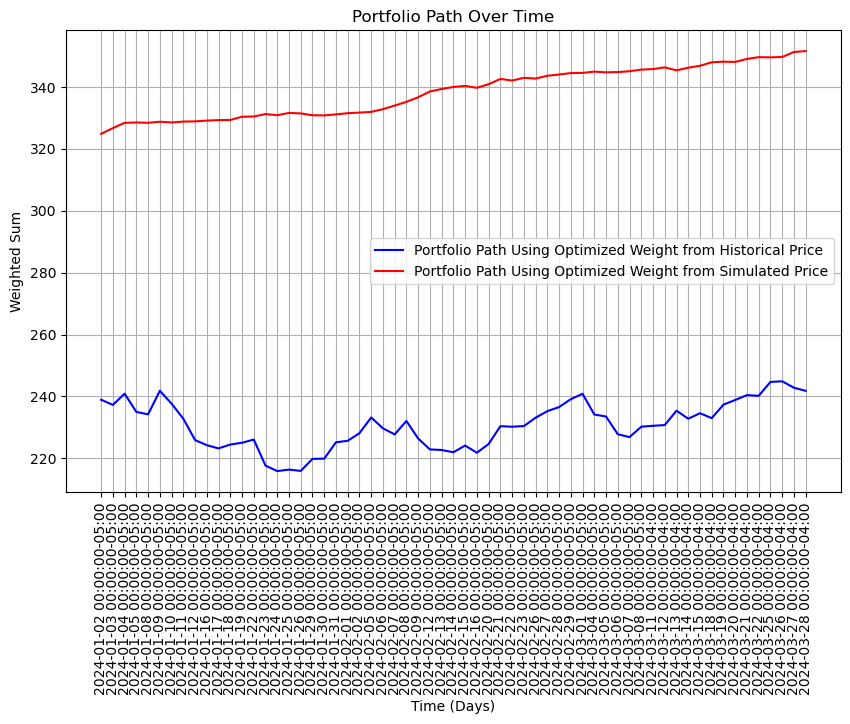

In [92]:
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(portfolio_path_old.index, portfolio_path_old['Portfolio Value'], label='Portfolio Path Using Optimized Weight from Historical Price', color='blue')
plt.plot(portfolio_path_new.index, portfolio_path_new['Portfolio Value'], label='Portfolio Path Using Optimized Weight from Simulated Price', color='red')
plt.title('Portfolio Path Over Time')  # Title of the plot
plt.xlabel('Time (Days)')  # Label for the x-axis
plt.ylabel('Weighted Sum')  # Label for the y-axis
plt.legend()  # Add a legend
plt.grid(True)  # Show grid
# Rotate x-axis labels to be vertical
plt.xticks(rotation=90)
plt.show()  # Display the plot

In [93]:
portfolio_path_old['Portfolio Value'][-1]

241.82195752312506

In [94]:
portfolio_path_new['Portfolio Value'][-1]

351.5371383856057

## Add Options